# Use JSON file from real-time data on the GHS pipeline 

This notebook runs the `src/analyze_api.py` workflow inline so you can inspect intermediate results and tweak parameters interactively.

Sections:

1. Setup imports & paths
2. Load pipeline helpers from `src`
3. Compute overall per-city CHS and per-post time series (with progress bars)
4. Save results to `results/api_1_analysis.json`


In [2]:
# 1) Setup imports and paths
import json
from pathlib import Path
from datetime import datetime

# progress bar (optional)
try:
    from tqdm import tqdm
except Exception:
    def tqdm(x, **_kw):
        return x

ROOT = Path('.')  # adjust if running from another cwd
DATA_PATH = ROOT / 'api_1.json'
OUT_DIR = ROOT / 'results'
OUT_DIR.mkdir(exist_ok=True)
OUT_FILE = OUT_DIR / 'api_1_analysis.json'

def ts_to_iso(ts):
    try:
        return datetime.fromtimestamp(int(ts)).isoformat() + 'Z'
    except Exception:
        return ''


In [3]:
# 2) Import the modularised pipeline helpers from src
# These are the functions you moved into src/ earlier.
try:
    from src.classify_sentiment import classify_with_sentiment
    from src.CHS_computation import (
        compute_topic_signed_scores,
        normalize_topic_scores_0_10,
        compute_CHS,
    )
except Exception as e:
    raise RuntimeError('Could not import pipeline modules. Ensure your PYTHONPATH and dependencies (transformers) are installed.') from e

print('Modules loaded: classify_with_sentiment, compute_topic_signed_scores, normalize_topic_scores_0_10, compute_CHS')


/home/ianyang/micromamba/envs/HTB2026/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0
Some weights of th

Modules loaded: classify_with_sentiment, compute_topic_signed_scores, normalize_topic_scores_0_10, compute_CHS


## 3) Run analysis per city (overall + per-post time series)
Runs the same steps as `src/analyze_api.py` but keeps results in the notebook for inspection.

In [6]:
# Load data
with open(DATA_PATH, 'r', encoding='utf-8') as f:
    data = json.load(f)


In [ ]:

results = []

for city in tqdm(data, desc='Cities'):
    city_name = city.get('city')
    posts = city.get('posts', []) or []

    # overall analysis using all texts
    texts_all = [p.get('text', '') for p in posts if p.get('text')]
    if texts_all:
        raw, details = compute_topic_signed_scores(texts_all, classify_with_sentiment, topk_mean=3, threshold=0.25)
        topic_0_10 = normalize_topic_scores_0_10(raw)
        chs = compute_CHS(topic_0_10)
    else:
        topic_0_10 = {t: 0.0 for t in []}
        chs = 0.0

    # per-post time series (chronological)
    timeseries = []
    posts_sorted = sorted(posts, key=lambda p: p.get('posted_at_timestamp', 0))
    for p in tqdm(posts_sorted, desc=f'Posts ({city_name})', leave=False):
        ts = p.get('posted_at_timestamp')
        text = p.get('text', '')
        if not text:
            continue
        raw_post, details_post = compute_topic_signed_scores([text], classify_with_sentiment, topk_mean=3, threshold=0.25)
        topic_post_0_10 = normalize_topic_scores_0_10(raw_post)
        chs_post = compute_CHS(topic_post_0_10)

        timeseries.append({
            'posted_at_timestamp': ts,
            'iso': ts_to_iso(ts) if ts is not None else '',
            'topic_scores_0_10': topic_post_0_10,
            'chs': chs_post,
            'text': text,
        })

    results.append({
        'city': city_name,
        'lat': city.get('lat'),
        'lng': city.get('lng'),
        'n_posts': len(posts),
        'overall_topic_scores_0_10': topic_0_10,
        'overall_chs': chs,
        'timeseries': timeseries,
    })

# save results
with open(OUT_FILE, 'w', encoding='utf-8') as f:
    json.dump(results, f, ensure_ascii=False, indent=2)

print(f'Wrote analysis to: {OUT_FILE}')

Cities:   0%|          | 0/186 [00:00<?, ?it/s]You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
/tmp/ipykernel_3398638/2808195562.py:21: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  return datetime.utcfromtimestamp(int(ts)).isoformat() + 'Z'
Cities: 100%|██████████| 186/186 [13:24<00:00,  4.33s/it] 


Wrote analysis to: results/api_1_analysis.json
Reading n_posts= 23 overall_chs= 5.0
Worth n_posts= 14 overall_chs= 4.7
Liverpool n_posts= 13 overall_chs= 4.8
Deal n_posts= 10 overall_chs= 4.7
Boston n_posts= 8 overall_chs= 5.0


In [4]:
# Show a short summary
for r in results[:5]:
    print(r['city'], 'n_posts=', r['n_posts'], 'overall_topic_scores_0_10=', r['overall_topic_scores_0_10'], 'overall_chs=', round(r['overall_chs'],1))

Reading n_posts= 23 overall_topic_scores_0_10= {'education': 5.0, 'life_satisfaction': 8.4, 'income': 4.9, 'access_to_services': 5.0, 'housing': 7.4, 'community': 3.5, 'jobs': 2.3, 'civic_engagement': 5.7, 'environment': 5.0, 'safety': 5.0, 'health': 5.0} overall_chs= 5.0
Worth n_posts= 14 overall_topic_scores_0_10= {'jobs': 5.0, 'income': 6.3, 'community': 2.7, 'civic_engagement': 6.4, 'life_satisfaction': 5.0, 'access_to_services': 5.0, 'safety': 2.1, 'environment': 5.0, 'health': 5.0, 'housing': 5.0, 'education': 5.0} overall_chs= 4.7
Liverpool n_posts= 13 overall_topic_scores_0_10= {'community': 4.2, 'life_satisfaction': 8.8, 'civic_engagement': 5.0, 'access_to_services': 5.4, 'safety': 5.0, 'jobs': 1.5, 'income': 5.0, 'environment': 5.0, 'health': 5.0, 'housing': 5.0, 'education': 5.0} overall_chs= 4.8
Deal n_posts= 10 overall_topic_scores_0_10= {'life_satisfaction': 5.8, 'access_to_services': 4.2, 'civic_engagement': 5.0, 'income': 5.0, 'housing': 1.3, 'environment': 5.0, 'safety

In [4]:
# Batch helpers: use with your existing src.* modules
from math import ceil
from collections import defaultdict
import numpy as np

import src.classify_sentiment as cs  # uses zshot, sentiment_clf, OECD_CATEGORIES
# optional: import compute helpers if you want to reuse them
from src.CHS_computation import CHS_WEIGHTS, OECD_TOPICS

def batch_classify_texts(texts, topk_mean=None, threshold=0.25, batch_size=32):
    """
    Return list of dicts equivalent to classify_with_sentiment(text).
    - texts: list[str]
    - topk_mean: passed to label aggregation
    - batch_size: model batch size for pipeline
    """
    T = len(texts)
    # per-category arrays: cat_scores[cat][i] = aggregated score for texts[i] for this category
    cat_scores = {cat: [0.0] * T for cat in cs.OECD_CATEGORIES.keys()}
    cat_best_label = {cat: [None] * T for cat in cs.OECD_CATEGORIES.keys()}
    cat_label_scores = {cat: [None] * T for cat in cs.OECD_CATEGORIES.keys()}

    # 1) For each category, run zshot on texts in chunks
    for cat, labels in cs.OECD_CATEGORIES.items():
        for start in range(0, T, batch_size):
            batch_texts = texts[start:start+batch_size]
            # pipeline accepts a list of sequences and returns list-of-dicts
            results = cs.zshot(batch_texts, candidate_labels=labels, multi_label=True, batch_size=batch_size)
            for idx, out in enumerate(results, start=start):
                label_scores = list(zip(out["labels"], out["scores"]))
                label_scores.sort(key=lambda x: x[1], reverse=True)
                if topk_mean and topk_mean > 1:
                    k = min(topk_mean, len(label_scores))
                    agg = float(np.mean([s for _, s in label_scores[:k]]))
                else:
                    agg = float(label_scores[0][1])
                cat_scores[cat][idx] = agg
                cat_best_label[cat][idx] = label_scores[0][0]
                cat_label_scores[cat][idx] = label_scores

    # 2) Sentiment for all texts in batches
    sent_results = []
    for start in range(0, T, batch_size):
        batch_texts = texts[start:start+batch_size]
        sent_batch = cs.sentiment_clf(batch_texts, batch_size=batch_size)
        sent_results.extend(sent_batch)

    # 3) Build per-text outputs (same keys as classify_with_sentiment)
    outputs = []
    for i in range(T):
        per_cat = {cat: cat_scores[cat][i] for cat in cs.OECD_CATEGORIES.keys()}
        best_cat, best_score = max(per_cat.items(), key=lambda kv: kv[1])
        is_confident = best_score >= threshold
        out = {
            "predicted_category": best_cat if is_confident else "none",
            "category_score": best_score,
            "top_keyword": cat_best_label[best_cat][i],
            "all_category_scores": per_cat,
            "explanation_top3_keywords": cat_label_scores[best_cat][i][:3] if cat_label_scores[best_cat][i] is not None else [],
            "sentiment": sent_results[i],
        }
        outputs.append(out)
    return outputs

def batch_compute_topic_signed_scores(texts, topk_mean=3, threshold=0.25, batch_size=32):
    """
    Returns (topic_scores_raw, details)
    - topic_scores_raw: dict[topic] -> mean signed score in [-1, 1]
    - details: list of per-post dicts (like your previous details)
    Implemented using batch_classify_texts to avoid sequential model calls.
    """
    outs = batch_classify_texts(texts, topk_mean=topk_mean, threshold=threshold, batch_size=batch_size)
    per_topic_values = defaultdict(list)
    details = []
    # helper sign mapping compatible with your CHS code
    def _sentiment_to_sign(sent_label: str) -> int:
        s = (sent_label or "").strip().lower()
        if s.startswith("pos"): return +1
        if s.startswith("neu"): return 0
        if s.startswith("neg"): return -1
        return 0

    for text, out in zip(texts, outs):
        pred_cat = out.get("predicted_category", "none")
        pred_score = float(out.get("category_score", 0.0))
        sent_label = out.get("sentiment", {}).get("label", "Neutral")
        sign = _sentiment_to_sign(sent_label)
        if pred_cat in OECD_TOPICS and pred_score > 0:
            signed = sign * pred_score
            per_topic_values[pred_cat].append(signed)
        details.append({
            "text": text,
            "predicted_category": pred_cat,
            "category_score": pred_score,
            "sentiment": sent_label,
            "signed_score": sign * pred_score if pred_cat in OECD_TOPICS else 0.0,
        })
    topic_scores_raw = {topic: (sum(vals)/len(vals)) if vals else 0.0 for topic, vals in per_topic_values.items()}
    for topic in OECD_TOPICS:
        topic_scores_raw.setdefault(topic, 0.0)
    return topic_scores_raw, details

In [ ]:
# 4) Run the batched analysis per city (fast)
results_batch = []

for city in tqdm(data, desc='Cities (batch)'):
    city_name = city.get('city')
    posts = city.get('posts', []) or []
    texts_all = [p.get('text', '') for p in posts if p.get('text')]

    if texts_all:
        # overall (uses batched classification under the hood)
        raw_overall, details_overall = batch_compute_topic_signed_scores(texts_all, topk_mean=3, threshold=0.25, batch_size=32)
        topic_0_10 = normalize_topic_scores_0_10(raw_overall)
        chs = compute_CHS(topic_0_10)

        # per-post outputs: classify all texts in a batch and derive per-post topic vectors
        outs = batch_classify_texts(texts_all, topk_mean=3, threshold=0.25, batch_size=32)
        timeseries = []
        # keep chronological order matching posts_sorted
        posts_sorted = sorted(posts, key=lambda p: p.get('posted_at_timestamp', 0))
        for p, out in zip(posts_sorted, outs):
            ts = p.get('posted_at_timestamp')
            text = p.get('text', '')
            pred_cat = out.get('predicted_category', 'none')
            pred_score = float(out.get('category_score', 0.0))
            sent_label = out.get('sentiment', {}).get('label', 'Neutral')
            # map sentiment to sign
            s = (sent_label or '').strip().lower()
            if s.startswith('pos'): sign = +1
            elif s.startswith('neu'): sign = 0
            elif s.startswith('neg'): sign = -1
            else: sign = 0
            signed = sign * pred_score
            # per-post raw topic vector (only predicted category has non-zero signed contribution)
            per_post_raw = {t: 0.0 for t in OECD_TOPICS}
            if pred_cat in OECD_TOPICS:
                per_post_raw[pred_cat] = signed
            per_post_0_10 = normalize_topic_scores_0_10(per_post_raw)
            chs_post = compute_CHS(per_post_0_10)

            timeseries.append({
                'posted_at_timestamp': ts,
                'iso': ts_to_iso(ts) if ts is not None else '',
                'topic_scores_0_10': per_post_0_10,
                'chs': chs_post,
                'text': text,
            })

    else:
        topic_0_10 = {t: 0.0 for t in OECD_TOPICS}
        chs = 0.0
        timeseries = []

    results_batch.append({
        'city': city_name,
        'lat': city.get('lat'),
        'lng': city.get('lng'),
        'n_posts': len(posts),
        'overall_topic_scores_0_10': topic_0_10,
        'overall_chs': chs,
        'timeseries': timeseries,
    })

# save batched results
with open(OUT_FILE.with_name('api_1_analysis_batched.json'), 'w', encoding='utf-8') as f:
    json.dump(results_batch, f, ensure_ascii=False, indent=2)

In [7]:
# read in the results from results_batch
with open(OUT_FILE.with_name('api_1_analysis_batched.json'), 'r', encoding='utf-8') as f:
    results_batch = json.load(f)

# brief summary
for r in results_batch[:5]:
    print(r['city'], 'n_posts=', r['n_posts'], 'overall_chs=', round(r['overall_chs'],1))


Reading n_posts= 23 overall_chs= 5.0
Worth n_posts= 14 overall_chs= 4.6
Liverpool n_posts= 13 overall_chs= 4.8
Deal n_posts= 10 overall_chs= 4.6
Boston n_posts= 8 overall_chs= 5.0


plots

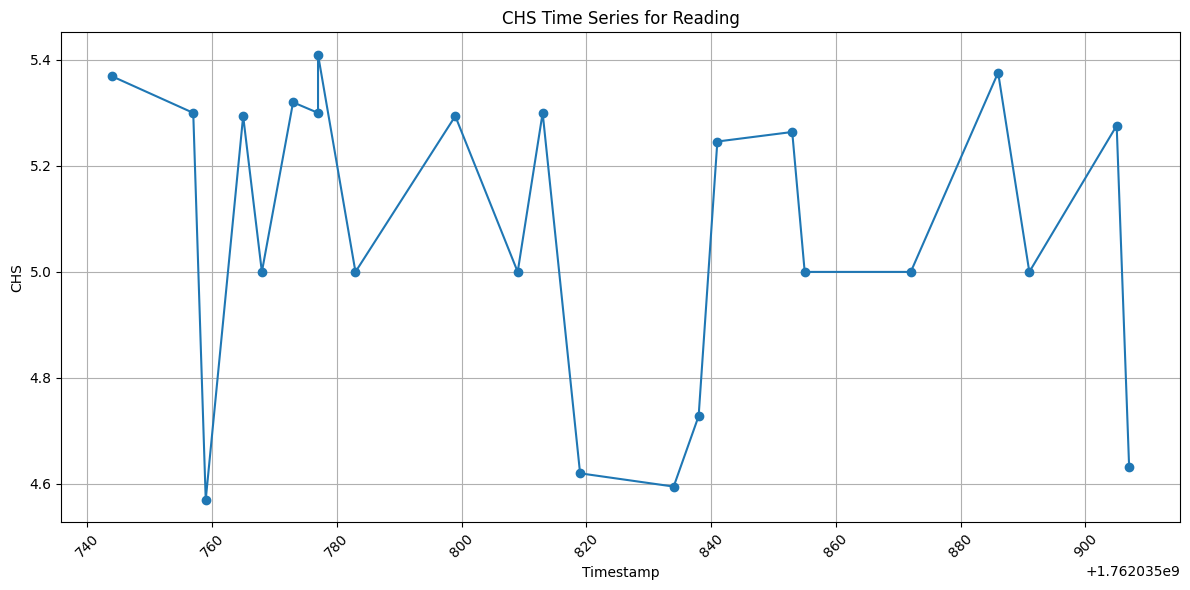

In [8]:
# plot the time series for the first city as an example
import matplotlib.pyplot as plt
city_example = results_batch[0]
times = [ts['posted_at_timestamp'] for ts in city_example['timeseries']]
chs_values = [ts['chs'] for ts in city_example['timeseries']]   

plt.figure(figsize=(12, 6))
plt.plot(times, chs_values, marker='o')
plt.title(f'CHS Time Series for {city_example["city"]}')
plt.xlabel('Timestamp')
plt.ylabel('CHS')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()
